# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [3]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [5]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean.csv")

In [6]:
#create your training and validation sets here

#assign size for data subset
subset_size = int(len(df) * 0.01)

#take random data subset
random_subset = df.sample(n=subset_size, random_state=42)

#split data subset 80/20 for train/validation
train_df = random_subset.sample(frac=0.8, random_state=42)
val_df = random_subset.drop(train_df.index) 



In [7]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [8]:
seq_arrays = []
seq_labs = []

In [9]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(len(train_df) - seq_length - ph):
    # Get the sequence of GAP values for the input sequence (last 30 minutes)
    seq = train_df[feat_cols].iloc[i:i+seq_length].values
    # Get the GAP value at the predictive horizon (5 minutes ahead)
    label = train_df[feat_cols].iloc[i+seq_length+ph-1].values[0]
    
    seq_arrays.append(seq)
    seq_labs.append(label)

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [10]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [11]:
seq_arrays.shape

(16359, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: seq_arrays.shape == (len(train_df)-seq_length-ph, seq_length, len(feat_cols))
seq_labs.shape == (len(train_df)-seq_length-ph,)
 and asserts allow us to perform sanity checks and verify expected values/shapes/types

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [12]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = 1
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(30, 1),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/Users/titouanmagret/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 6s - 186ms/step - loss: 1.5801 - mse: 1.5801 - val_loss: 1.0201 - val_mse: 1.0201
Epoch 2/100
32/32 - 1s - 29ms/step - loss: 1.1982 - mse: 1.1982 - val_loss: 1.0195 - val_mse: 1.0195
Epoch 3/100
32/32 - 1s - 27ms/step - loss: 1.1752 - mse: 1.1752 - val_loss: 1.0178 - val_mse: 1.0178
Epoch 4/100
32/32 - 1s - 24ms/step - loss: 1.1705 - mse: 1.1705 - val_loss: 1.0182 - val_mse: 1.0182
Epoch 5/100
32/32 - 1s - 28ms/step - loss: 1.1622 - mse: 1.1622 - val_loss: 1.0177 - val_mse: 1.0177
Epoch 6/100
32/32 - 1s - 24ms/step - loss: 1.1573 - mse: 1.1573 - val_loss: 1.0183 - val_mse: 1.0183
Epoch 7/100
32/32 - 1s - 24ms/step - loss: 1.1510 - mse: 1.1510 - val_loss: 1.0183 - val_mse: 1.0183
Epoch 8/100
32/32 - 1s - 25ms/step - loss: 1.1458 - mse: 1.1458 - val_loss: 1.0177 - val_mse: 1.0177
Epoch 9/100
32/32 - 1s - 24ms/step - loss: 1.1438 - mse: 1.1438 - val_loss: 1.0190 - val_mse: 1.0190
Epoch 10/100
32/32 - 1s - 25ms/step - loss: 1.1438 - mse: 1.1438 - val_loss: 1.0179 -

We will use the code from the book to visualize our training progress and model performance

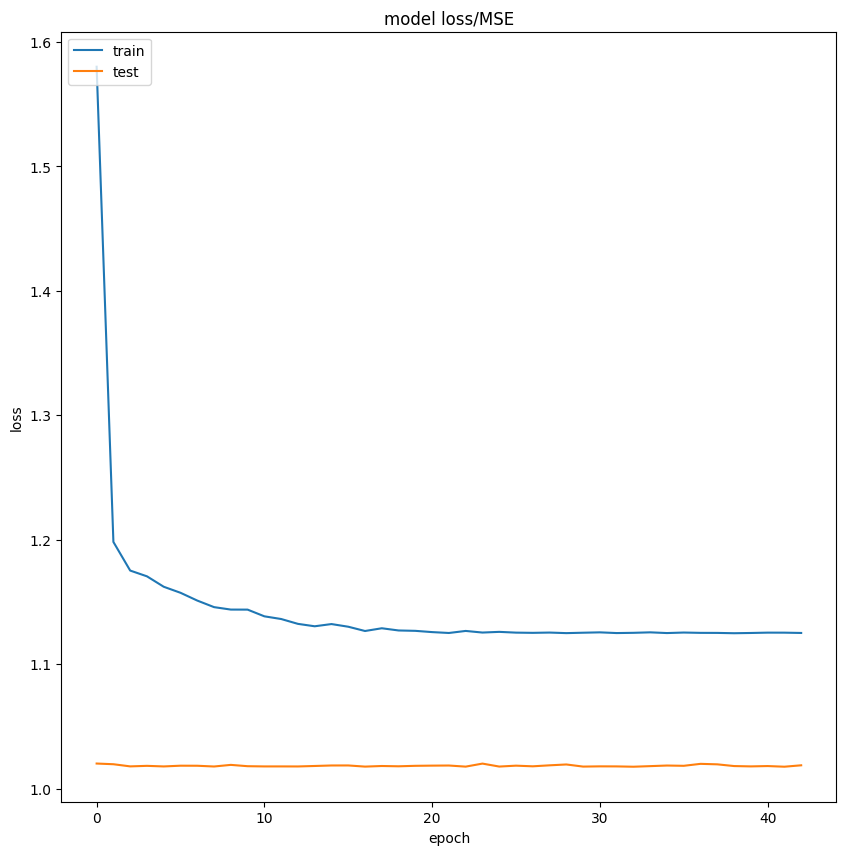

In [13]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function ensures that sequences of different lengths are padded to the same length. It does this by either adding padding at the beginning (pre) or at the end (post) of the sequences.

In [14]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(len(val_df) - seq_length - ph):
    # Start by collecting GAP values for the input sequence
    seq = val_df[feat_cols].iloc[i:i+seq_length].values
    # Get the GAP value at the predictive horizon (5 minutes ahead)
    label = val_df[feat_cols].iloc[i+seq_length+ph-1].values[0]
    
    val_arrays.append(seq)
    val_labs.append(label)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre', value=0.0)
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 1s - 10ms/step - loss: 1.1395 - mse: 1.1395

MSE: 1.1395124197006226
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


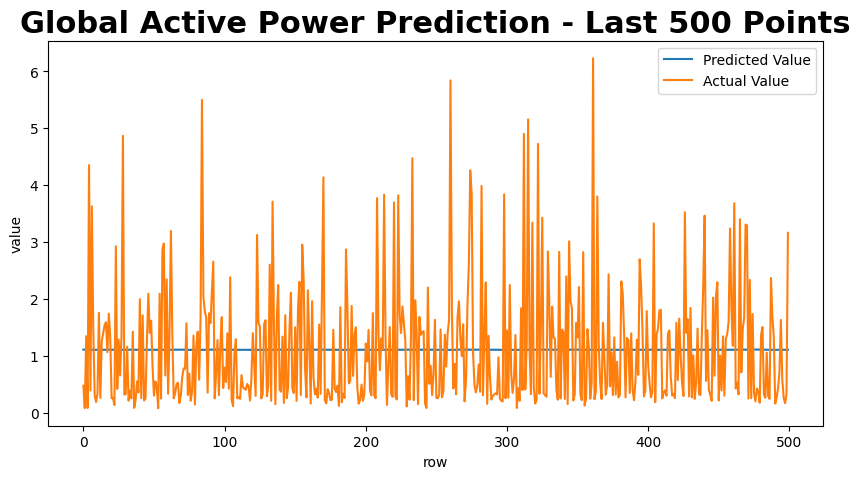

In [15]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: If the training loss keeps decreasing but the validation loss stops improving (or increases), it indicates that the model is overfitting. This is a common issue where the model learns to perform well on training data but fails to generalize to unseen data. The model performed adequetally. 


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: Add More Variables to the Input Sequences, Adjust the Optimizer and Learning Rate, Change the Sequence Length and Predictive Horizon

In [19]:
# play with your ideas for optimization here
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

# Define model path
model_path = 'optimized_LSTM_model.keras'

# Model Architecture
nb_features = 2  # Use two features (Global_active_power and Global_reactive_power)
nb_out = 1  # Predicting one value (Global_active_power)

model = Sequential()

# Add 1D Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, nb_features)))
model.add(MaxPooling1D(pool_size=2))

# Add first LSTM layer
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))  # Increase dropout rate to 30% for better regularization

# Add second LSTM layer
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.3))

# Dense layer for output
model.add(Dense(units=nb_out))
model.add(Activation('linear'))  # No activation function for regression task

# Compile the model with a different optimizer
optimizer = RMSprop(learning_rate=0.001)  # Use RMSprop with lower learning rate
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Print model summary
print(model.summary())

# Fit the model using training data
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# Evaluate the model
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print(f'\nMSE: {scores_test[1]}')

# Make predictions
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Save predictions to CSV
test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('optimized_test_predictions.csv', index=None)

# Visualize the predictions vs. actuals
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label='Predicted Value')
plt.plot(y_true_test[-500:], label='Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Row')
plt.legend()
plt.show()

# Save the plot
fig_verify.savefig("optimized_model_regression_verify.png")

Epoch 1/100


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv1d_3" is incompatible with the layer: expected axis -1 of input shape to have value 2, but received input with shape (None, 30, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 30, 1), dtype=float32)
  • training=True
  • mask=None

In [ ]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:  Additional Features: Adding more features like Global_reactive_power should help the model learn better patterns from the data. Multiple features provide more context, which may improve the model's ability to predict Global_active_power accurately.

Convolutional Layer: The 1D convolutional layer is designed to capture local patterns in the input data. This can help identify time-dependent structures that a simple LSTM layer may not be able to detect alone.

More LSTM Units: By increasing the number of units in the LSTM layers, the model gains more capacity to learn from the input data, especially if the relationships between the time steps are complex.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: 